In [1]:
import os
import pprint
import pandas as pd
import sys
sys.path.insert(0, '../src/')

import pairformance
import plotting_utils

pp = pprint.PrettyPrinter(indent=4)

from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

### Load example data

In [5]:
eval_df = pd.read_csv('dialogue_example_df.csv')
eval_df.head()

,M0,M1,M2,M3,M4
0,0.494745,0.506390,0.483005,0.506464,0.491332
1,0.508530,0.500055,0.501631,0.488402,0.497688
2,0.483350,0.480694,0.487698,0.491429,0.502955
3,0.478844,0.486405,0.476397,0.498539,0.479826
4,0.521780,0.500513,0.503646,0.499146,0.541854


In [8]:
print(f" Systems: {eval_df.columns.to_list()},\n number of test instances: {eval_df.shape[0]}")

 Systems: ['M0', 'M1', 'M2', 'M3', 'M4'],
 number of test instance: 60


## Start Pairformance

In [11]:
print("Default config:")
pp.pprint(pairformance.DEFAULT_CONFIG)

Default config:
{   'aggregations': ['Mean', 'Median', 'BT'],
    'compute_pairwise': True,
    'epsilon_bt': 1e-09,
    'n_bootstrap': 100,
    'pval_threshold': 0.05}


- `aggregations`: a list of aggregation mechanisms to consider
- `compute_pairwise`: whether to run the analyses for each pair of systems
- `epsilon_bt`: when the iterative algorithm of BT does not vary by more than epsilon_bt, we stop.
- `n_bootstrap`: number of bootstrap resample of the data to take to compute confidence intervals
- `pval_threshold`: percentile to use for confidence interval. Example: 0.05 gives the (5, 95) percentiles.

In [12]:
pf_config = pairformance.DEFAULT_CONFIG
pf_config['n_bootstrap'] = 10

pf_eval = pairformance.Pairformance(df=eval_df, config=pf_config)

## Default Usage

In [21]:
results = pf_eval.eval()
global_results = pf_eval.print_global_results()
pairwise_results = pf_eval.print_pairwise_results()



===== Global Results =====

*** Mean ***
	     Systems       Est. score    (95% bootstrap CI)
	       M0             0.507      (0.504, 0.512) 
	       M1             0.507      (0.496, 0.513) 
	       M2             0.507      (0.497, 0.523) 
	       M3             0.502      (0.497, 0.508) 
	       M4             0.514      (0.509, 0.518) 

*** Median ***
	     Systems       Est. score    (95% bootstrap CI)
	       M0             0.503      (0.499, 0.508) 
	       M1             0.495      (0.489, 0.500) 
	       M2             0.497      (0.494, 0.499) 
	       M3             0.495      (0.492, 0.499) 
	       M4             0.507      (0.501, 0.512) 

*** BT ***
	     Systems       Est. score    (95% bootstrap CI)
	       M0             0.239      (0.191, 0.300) 
	       M1             0.133      (0.109, 0.180) 
	       M2             0.168      (0.121, 0.220) 
	       M3             0.151      (0.126, 0.174) 
	       M4             0.308      (0.259, 0.390) 


===== Pairwise Res

### Description of the returned variables

**Outputs from pf_eval.eval()**:
- `results['global-results']`: contains the global estimates for each aggregation mechanism defined in the config
- `results['global-results'][Agg]`: is a pd.DataFrame with n_bootstrap row, one row for one resampled estimate
- `results['pairwise-results']`: contains the pairwise comparison for each pair of systems

**Outputs from self.print_global_results()**: the same information as `results['global-results']` but with the confidence intervals computed from the resampled estimates.

**Outputs from self.print_pairwise_results()**: the same information as `results['pairwise-results']` but with the confidence intervals computed from the resampled estimates

## Probability that one system is better than other

In [23]:
p_m0_m1, pval_m0_m1 = pf_eval.prob_a_better_b('M0', 'M1')
print(f"Prob that M0 is better than M1 {p_m0_m1}, pval {pval_m0_m1}")

Prob that M0 is better than M1 0.65, pval 0.02734013386807794


## Visualization of results

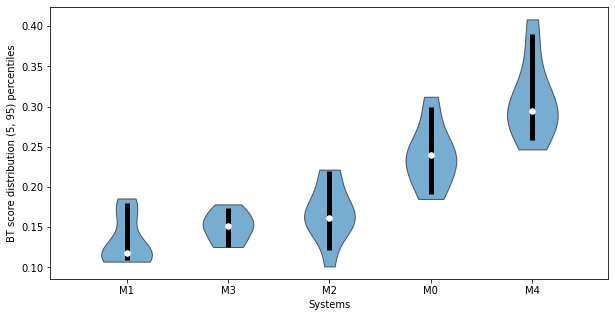

In [32]:
## Plot the distribution of BT estimates coming from bootstrap resamples
plotting_utils.plot_global_results(pf_eval, aggregation='BT')

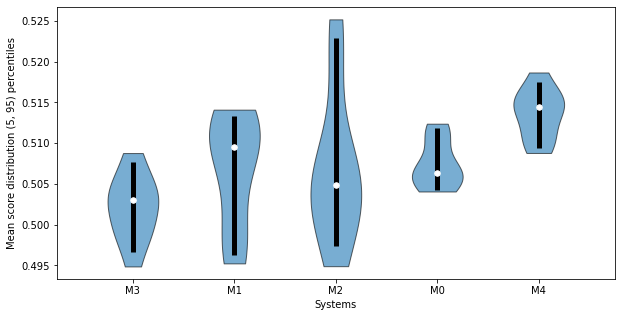

In [31]:
## Plot the distribution of mean estimates coming from bootstrap resamples
plotting_utils.plot_global_results(pf_eval, aggregation='Mean')

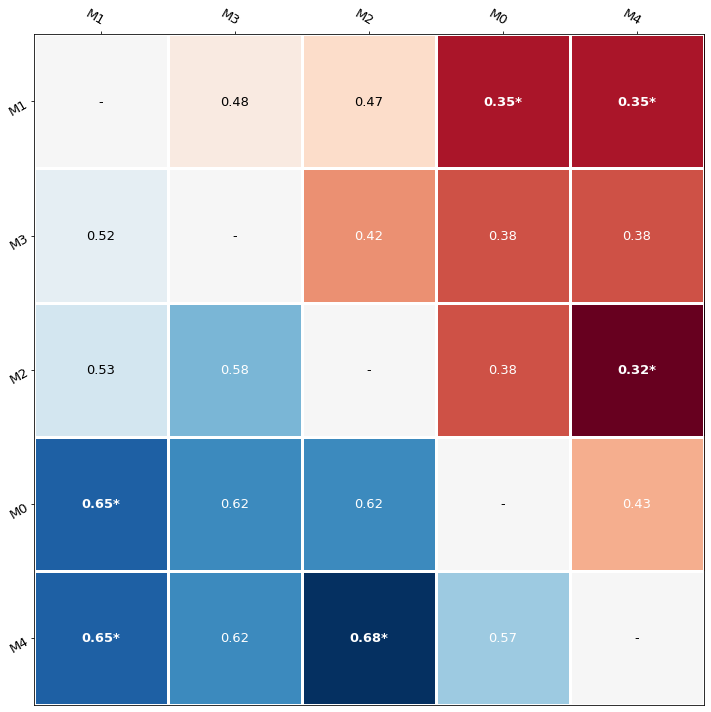

In [33]:
## Plot pairwise structure for BT (BT pairwise is different than BT global)
plotting_utils.plot_matrix_results(pf_eval, aggregation='BT', fontsize=13, save_path=None)

In this matrix, the element at row i and column j is the probability that the system of row i is better than the system of column j

The star marks statistically significant difference according to the sign test (for BT)

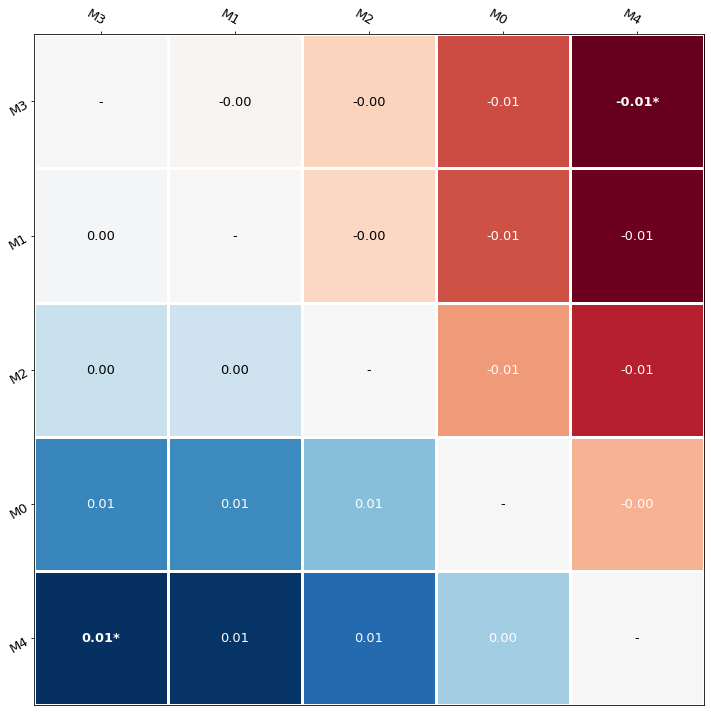

In [34]:
plotting_utils.plot_matrix_results(pf_eval, aggregation='Median', fontsize=13, save_path=None)

In this matrix, the element at row i and column j is the difference between the median of system of row i and the system of column j
The star marks statistically significant difference according to the Mood\'s median test (for Median)

## Diagnostic capabilities

### Computing statistics of the system scores

- `global-outliers-percentage`: take the whole array of data and compute the percentage of outliers
- `per-system-outliers-percentage`: percentage of outliers for each system independently
- `mean-row-std`: measure the std per test instance, then average this std across test instances, i.e., how much variance is there across system 
- `rank-std-across-rows`: computes the order of systems per test instance, and measure how much the ranking varies across test instances, i.e., how much variance is there across ranking of systems
- `std-of-row-means`: computes the mean score of each test instance (across systems) and measure the std across test instances, i.e., how much overall scores vary across test instances

In [36]:
pp.pprint(pf_eval.diagnostic_system_scores(eval_df))

{   'global-outliers-percentage': 0.04,
    'mean-row-std': 0.023165780310952244,
    'per-system-outliers-percentage': {   'M0': 0.03333333333333333,
                                          'M1': 0.1,
                                          'M2': 0.05,
                                          'M3': 0.03333333333333333,
                                          'M4': 0.016666666666666666},
    'rank-std-across-rows': {   'M0': 1.3591082154276524,
                                'M1': 1.4000605313790626,
                                'M2': 1.3591082154276524,
                                'M3': 1.3567158752302175,
                                'M4': 1.4319793894296853},
    'std-of-row-means': 0.02784875417780158}


### Computing disagreements between the aggregation mechanisms for this data

In this case, we observe that there is good agreement between mean, median, and BT

In [40]:
_ = pf_eval.diagnostic_aggregation_agreement()



===== Aggregation Agreement =====
	       Pairs of Agg.       Percentage Aggr.    Same Sota      Same Top-3   
	      Mean vs. Median           1.00            True            True      
	        Mean vs. BT             0.90            True            True      
	       Median vs. BT            0.90            True            True      


### plotting paired graph

It show the paired structure of a pair of system. 
Each dot is one test instances whose coordinates are given by the score it receives according to the two systems.
This is shown as a density plot, if more density is above the dotted line the y-axis system is better according to BT.
Otherwise, the x-axis system is better according to BT.
See paper for more details!

In this case, the medians intersects below the dotted line, i.e., Median makes M1 better
More mass is on the space above the dotted line, i.e., BT makes M2 better
The means intersect on the dotted line, i.e., Mean does not distinguish between M2 and M1

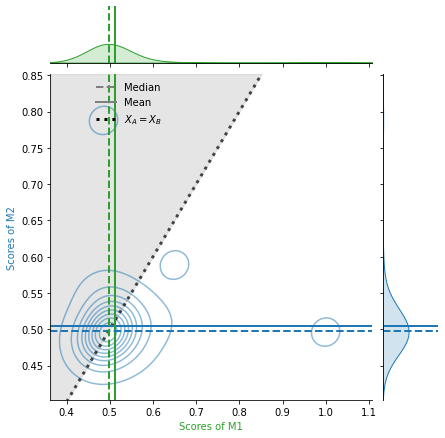

In [42]:
plotting_utils.plot_paired_graphs(eval_df, 'M2', 'M1')